In [49]:
#Step 0. Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [50]:
download('wordnet')
download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
stop_words = stopwords.words('english')

In [52]:
#Step 1. Load Dta
url = "https://breathecode.herokuapp.com/asset/internal-link?id=932&path=url_spam.csv"
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [53]:
df_raw.sample(10, random_state=2025)

,url,is_spam
1897,https://briefingday.com/fan,True
98,https://seattle.eater.com/2020/6/18/21293916/s...,False
141,https://www.buzzfeednews.com/article/tanyachen...,False
2128,https://www.nytimes.com/2020/06/29/movies/sund...,False
2953,http://gettheelevator.com/editorial,True
2537,https://www.theverge.com/2020/6/29/21304947/re...,False
1801,https://www.earios.net/,False
1024,https://old.reddit.com/r/AskReddit/comments/he...,False
37,https://www.theobservereffect.org/marc.html,False
4,https://briefingday.com/fan,True


In [54]:
#Step 2. Preprocessing
df_baking = df_raw.copy()
df_baking['is_spam'] = df_baking['is_spam'].astype("string").str.lower()
df_baking['is_spam'] = df_baking['is_spam'].str.strip()
df_baking['is_spam'] = df_baking['is_spam'].apply(lambda x: "1" if x == "true" else "0")
df_baking['is_spam'] = df_baking['is_spam'].astype("category")
df_baking = df_baking.drop_duplicates()
def preprocess_text(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)

    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)
    text = re.sub("www","", text)
    text = re.sub("com","", text)
    text = re.sub("https","", text)
    text = re.sub("http","", text)
    text = re.sub("org","", text)
    text = re.sub("html","", text)
    text = re.sub("co","", text)
    text = re.sub("net","", text)

    #Reemplazar texto
    text = re.sub("ronavirus", "coronavirus",text)
    text = re.sub("ntainer", "container",text)
    return text.split()

df_baking["url"] = df_baking["url"].apply(preprocess_text)
df = df_baking.copy()
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2369 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   url      2369 non-null   object  
 1   is_spam  2369 non-null   category
dtypes: category(1), object(1)
memory usage: 39.5+ KB


In [55]:
df


,url,is_spam
0,"[briefingday, us, list, manage, unsubscribe]",1
1,[hvper],1
2,"[briefingday, v, i]",1
3,"[briefingday, m, mentform]",0
4,"[briefingday, fan]",1
...,...,...
2993,"[theverge, disney, deepfake, face, swapping, r...",0
2994,"[smartcitiesworld, news, news, deepfake, techn...",0
2996,"[techcrunch, an, optimistic, view, of, deepfakes]",0
2997,"[technologyreview, this, startup, claims, its,...",0


In [56]:
#Step 3. EDA
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['is_spam'], random_state=2025)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train.shape, df_test.shape

((1895, 2), (474, 2))

In [57]:
df_train.describe().T

,count,unique,top,freq
url,1895,1844,"[briefingday, m, mentform]",12
is_spam,1895,2,0,1700


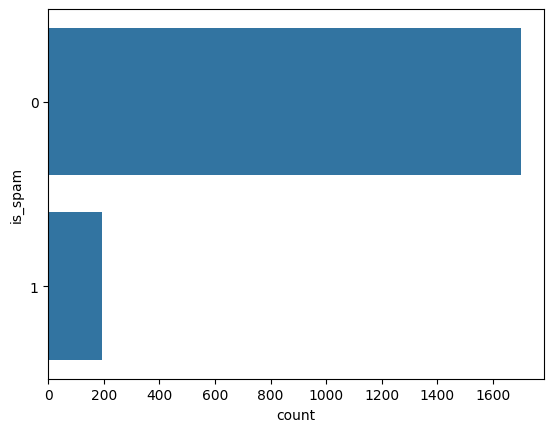

In [58]:
sns.countplot(df_train, y='is_spam')
plt.show()

In [59]:
#Lematizacion y eliminacion de texto irrelevante
#Lematizer and Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

df_train["url"] = df_train["url"].apply(lemmatize_text)
df_train

,url,is_spam
0,"[brynjolfsson, remotework]",0
1,"[nasa, mission, page, chandra, news, black, ho...",0
2,"[tribunemag, disaster, automation, waiting]",0
3,"[deceuvel, anisatie]",0
4,"[digg, video, relationship, advice]",0
...,...,...
1890,"[history, news, olympic, marathon, outlandish,...",0
1891,"[usatoday, story, news, politics, supreme, uph...",0
1892,"[thesun, news, uknews, euromillions, adrian, b...",0
1893,"[mashable, article, reddit, history, anniversary]",0


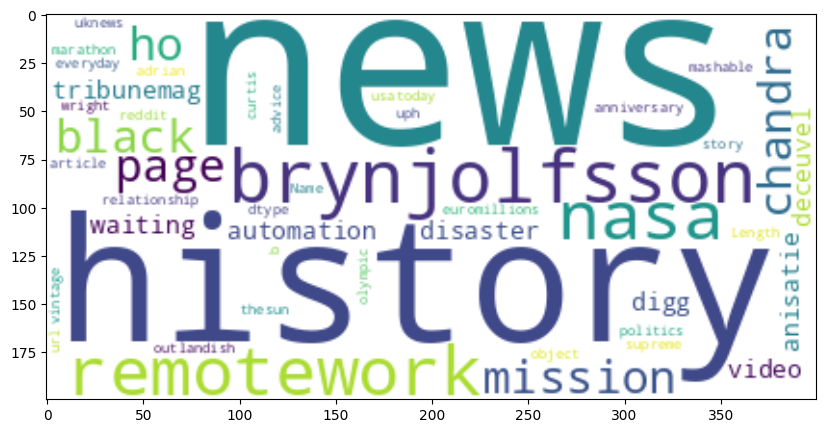

In [60]:
#Nube de palabras general
wc = WordCloud(
    max_words = 100,
    background_color = 'White',
    collocations=False,
).generate(str(df_train["url"]))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.show()

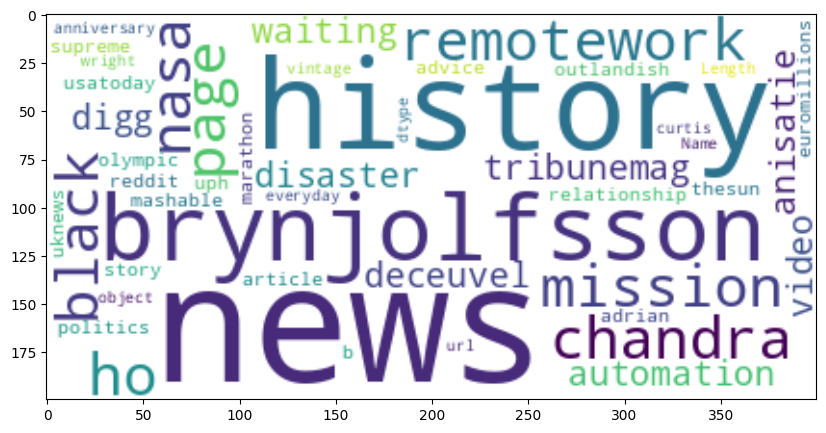

In [61]:
#Nube de palabras que no son spam
wc = WordCloud(
    max_words = 100,
    background_color = 'White',
    collocations=False
).generate(str(df_train[df_train['is_spam'] == '0']['url']))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.show()

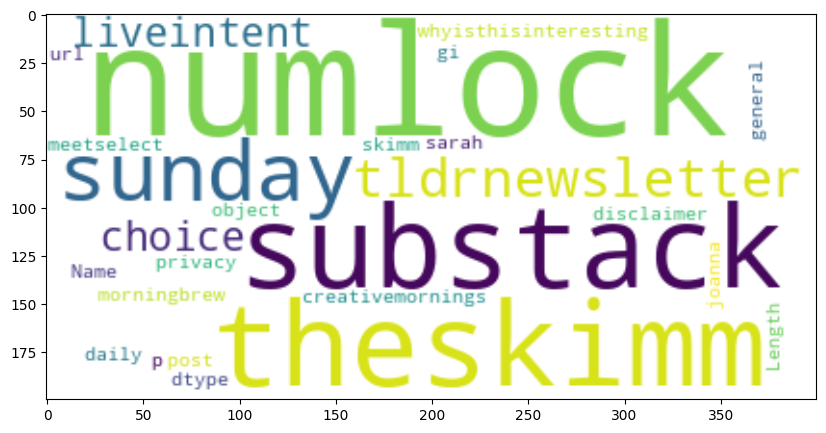

In [62]:
#Nube de palabras que son spam
wc = WordCloud(
    max_words = 100,
    background_color = 'White',
    collocations=False
).generate(str(df_train[df_train['is_spam'] == '1']['url']))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.show()

In [63]:
#Step 4. Machine Learning

tokens_train_X = df_train['url'].apply(lambda tokens: " ".join(tokens))
y_train = df_train['is_spam']

tokens_test_X = df_test['url'].apply(lambda tokens: " ".join(tokens))
y_test = df_test['is_spam']

In [64]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words= stop_words)
X_train = vectorizer.fit_transform(tokens_train_X)
X_test = vectorizer.transform(tokens_test_X)

vectorizer

TfidfVectorizer(max_features=5000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...])

In [65]:
model = SVC(kernel='linear', random_state=2025, class_weight='balanced')
model.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear', random_state=2025)

In [66]:
y_hat = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_hat):.2f}')

Accuracy: 0.89


In [67]:
print(classification_report(y_test, y_hat, target_names=["False","True"]))


              precision    recall  f1-score   support

       False       0.96      0.91      0.94       425
        True       0.48      0.69      0.57        49

    accuracy                           0.89       474
   macro avg       0.72      0.80      0.75       474
weighted avg       0.91      0.89      0.90       474



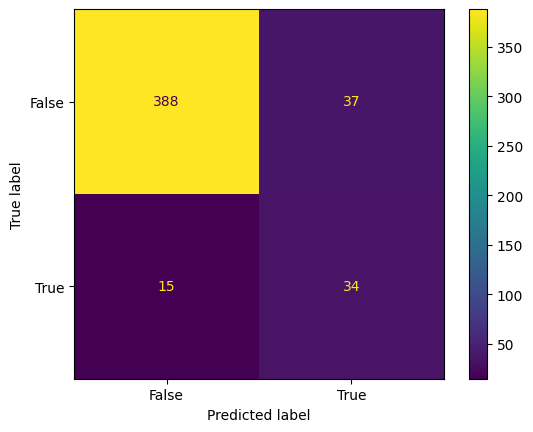

In [68]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, display_labels=["False","True"])
plt.show()

In [69]:
scv_cv = GridSearchCV( #Numero de combinaciones de busqueda = 7x3x3, es decir la cantidad de elementos que tiene nuestro paramgrid
    model,
    param_grid={
      'C': [0.1, 1, 10, 100],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.01, 0.001]
}
)
#Con este algoritmo buscamos los mejores parametros de tree decision
scv_cv.fit(X_train, y_train)
scv_cv.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [70]:
model_new = SVC(C=10, gamma=0.1, kernel='rbf', random_state=2025, class_weight="balanced")
model_new.fit(X_train, y_train)
y_hat_new = model_new.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_hat_new):.2f}')

Accuracy: 0.90


In [72]:
print(classification_report(y_test, y_hat_new, target_names=["False","True"]))

              precision    recall  f1-score   support

       False       0.97      0.92      0.94       425
        True       0.51      0.71      0.60        49

    accuracy                           0.90       474
   macro avg       0.74      0.82      0.77       474
weighted avg       0.92      0.90      0.91       474



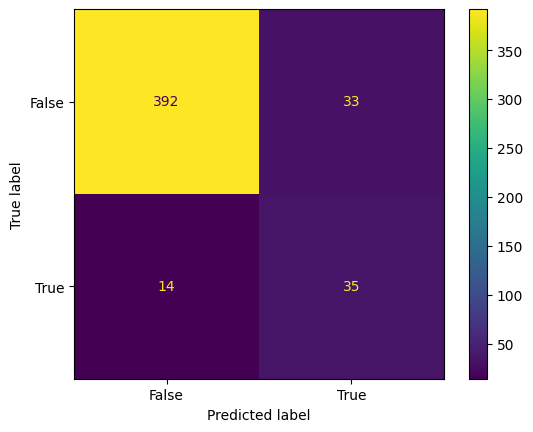

In [71]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat_new, display_labels=["False","True"])
plt.show()